# Sepsis Cases Project


In [85]:
import pm4py
import pandas as pd


#### Load the CSV and XES files

In [86]:
df = pd.read_csv('Sepsis Cases - Event Log.csv')
log = pm4py.read_xes("Sepsis Cases - Event Log.xes", variant="iterparse20")

df.head()

,Unnamed: 0,InfectionSuspected,org:group,DiagnosticBlood,DisfuncOrg,SIRSCritTachypnea,Hypotensie,SIRSCritHeartRate,Infusion,DiagnosticArtAstrup,concept:name,Age,DiagnosticIC,DiagnosticSputum,DiagnosticLiquor,DiagnosticOther,SIRSCriteria2OrMore,DiagnosticXthorax,SIRSCritTemperature,time:timestamp,DiagnosticUrinaryCulture,SIRSCritLeucos,Oligurie,DiagnosticLacticAcid,lifecycle:transition,Diagnose,Hypoxie,DiagnosticUrinarySediment,DiagnosticECG,case:concept:name,Leucocytes,CRP,LacticAcid
0,0,True,A,True,True,True,True,True,True,True,ER Registration,85.0,True,False,False,False,True,True,True,2014-10-22 11:15:41+00:00,True,False,False,True,complete,A,False,True,True,A,NaN,NaN,NaN
1,1,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Leucocytes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-10-22 11:27:00+00:00,NaN,NaN,NaN,NaN,complete,NaN,NaN,NaN,NaN,A,9.6,NaN,NaN
2,2,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CRP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-10-22 11:27:00+00:00,NaN,NaN,NaN,NaN,complete,NaN,NaN,NaN,NaN,A,NaN,21.0,NaN
3,3,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LacticAcid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-10-22 11:27:00+00:00,NaN,NaN,NaN,NaN,complete,NaN,NaN,NaN,NaN,A,NaN,NaN,2.2
4,4,NaN,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ER Triage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-10-22 11:33:37+00:00,NaN,NaN,NaN,NaN,complete,NaN,NaN,NaN,NaN,A,NaN,NaN,NaN


In [87]:
n_traces = len(log["case:concept:name"].unique())
print(f"number of traces: {n_traces}")

number of traces: 1050


In [88]:
# Group by 'case_id' and concatenate the events for each trace
trace_df = df.groupby('case:concept:name')['org:group'].apply(lambda x: ','.join(x)).reset_index()

# Count the occurrences of each unique trace
trace_counts = trace_df['org:group'].value_counts()

# Rename the column for display purposes
trace_counts = trace_counts.rename_axis('Trace').reset_index(name='Count')

# Print the results without the index
print(trace_counts.head(10).to_string(index=False))

                    Trace  Count
                A,C,A,B,B     46
          A,C,A,B,B,B,A,A     42
                    A,C,A     31
              A,C,A,B,B,B     21
          A,C,A,A,A,B,B,B     10
          A,C,B,B,B,A,A,A      9
          A,C,A,A,B,B,B,A      9
                A,C,B,B,A      7
  A,C,A,B,B,B,A,A,O,B,B,E      7
A,C,A,B,B,B,A,A,F,B,B,E,?      7


In [89]:
activity_attribute = "concept:name"
activities = log.groupby(activity_attribute)[activity_attribute].count()
resource_attribute = "org:group"
activities_resources = log.groupby(activity_attribute)[resource_attribute].unique().agg(", ".join)
display(pd.merge(activities, activities_resources, left_index=True, right_index=True)["org:group"])

C:\Users\mayan\AppData\Local\Temp\ipykernel_39144\3462307038.py:4: FutureWarning: using <built-in method join of str object at 0x000001F05A701680> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  activities_resources = log.groupby(activity_attribute)[resource_attribute].unique().agg(", ".join)


concept:name
Admission IC                                                        J, P, K, W
Admission NC        D, F, G, H, I, J, K, M, N, O, Q, R, S, T, U, V, P, X, W, Y
CRP                                                                          B
ER Registration                                                           A, L
ER Sepsis Triage                                                          A, L
ER Triage                                                                    C
IV Antibiotics                                                            A, L
IV Liquid                                                                 A, L
LacticAcid                                                                   B
Leucocytes                                                                   B
Release A                                                                    E
Release B                                                                    E
Release C                              

#### Most common process variants

In [90]:
variants = pm4py.get_variants(log)
common_variants = pd.DataFrame(variants.items(), columns=["variant", "count"]).sort_values("count", ascending=False)
common_variants["percentile"] = common_variants["count"] / common_variants["count"].sum() * 100
pd.set_option("display.max_colwidth", None)
common_variants.head(10)[["variant", "count", "percentile"]]

,variant,count,percentile
21,"(ER Registration, ER Triage, ER Sepsis Triage)",35,3.333333
24,"(ER Registration, ER Triage, ER Sepsis Triage, Leucocytes, CRP)",24,2.285714
95,"(ER Registration, ER Triage, ER Sepsis Triage, CRP, Leucocytes)",22,2.095238
3,"(ER Registration, ER Triage, ER Sepsis Triage, CRP, LacticAcid, Leucocytes, IV Liquid, IV Antibiotics)",13,1.238095
36,"(ER Registration, ER Triage, ER Sepsis Triage, Leucocytes, CRP, LacticAcid)",11,1.047619
139,"(ER Registration, ER Triage, ER Sepsis Triage, Leucocytes, CRP, LacticAcid, IV Liquid, IV Antibiotics)",9,0.857143
1,"(ER Registration, ER Triage, ER Sepsis Triage, Leucocytes, LacticAcid, CRP, IV Liquid, IV Antibiotics)",7,0.666667
158,"(ER Registration, ER Triage, ER Sepsis Triage, Leucocytes, CRP, Admission NC, Release A)",5,0.476190
232,"(ER Registration, ER Triage, ER Sepsis Triage, LacticAcid, Leucocytes, CRP, IV Liquid, IV Antibiotics)",5,0.476190
83,"(ER Registration, ER Triage, ER Sepsis Triage, CRP, Leucocytes, LacticAcid, IV Liquid, IV Antibiotics)",5,0.476190


In [91]:
start_activities = pm4py.stats.get_start_activities(log)
end_activities = pm4py.stats.get_end_activities(log)
print("Start activities:")
display(start_activities)
print("End activities:")
display(end_activities)

Start activities:


{'ER Registration': 995,
 'IV Liquid': 14,
 'ER Triage': 6,
 'CRP': 10,
 'ER Sepsis Triage': 7,
 'Leucocytes': 18}

End activities:


{'Release A': 393,
 'Return ER': 291,
 'IV Antibiotics': 87,
 'Release B': 55,
 'ER Sepsis Triage': 49,
 'Leucocytes': 44,
 'IV Liquid': 12,
 'Release C': 19,
 'CRP': 41,
 'LacticAcid': 24,
 'Release D': 14,
 'Admission NC': 14,
 'Release E': 5,
 'ER Triage': 2}

In [92]:
initial_log_len = len(log)

valid_star_activity = {"ER Registration"}
valid_end_activities = {"Release A", "Release B", "Release C", "Release D", "Release E", "Return ER"}

log = pm4py.filter_start_activities(log, valid_star_activity)
log = pm4py.filter_end_activities(log, valid_end_activities)

print("Filtered log length:", len(log))
print((initial_log_len - len(log))/initial_log_len)
n_traces = len(log["case:concept:name"].unique())
print(f"Remaining traces: {n_traces}")

Filtered log length: 12436
0.18259497830945182
Remaining traces: 734


In [93]:
start_activities = pm4py.stats.get_start_activities(log)
end_activities = pm4py.stats.get_end_activities(log)
print("Start activities:")
display(start_activities)
print("End activities:")
display(end_activities)

Start activities:


{'ER Registration': 734}

End activities:


{'Release A': 376,
 'Return ER': 275,
 'Release B': 49,
 'Release C': 16,
 'Release D': 13,
 'Release E': 5}

In [94]:
variants = pm4py.get_variants(log)
common_variants = pd.DataFrame(variants.items(), columns=["variant", "count"]).sort_values("count", ascending=False)
common_variants["percentile"] = common_variants["count"] / common_variants["count"].sum() * 100
pd.set_option("display.max_colwidth", None)
common_variants.head(10)[["variant", "count", "percentile"]]

,variant,count,percentile
122,"(ER Registration, ER Triage, ER Sepsis Triage, Leucocytes, CRP, Admission NC, Release A)",5,0.681199
183,"(ER Registration, ER Triage, ER Sepsis Triage, LacticAcid, Leucocytes, CRP, IV Liquid, IV Antibiotics, Admission NC, Release A)",4,0.544959
48,"(ER Registration, ER Triage, ER Sepsis Triage, CRP, Leucocytes, Admission NC, Release A)",4,0.544959
213,"(ER Registration, ER Triage, ER Sepsis Triage, Leucocytes, LacticAcid, CRP, IV Liquid, IV Antibiotics, Admission NC, CRP, Leucocytes, Release A)",4,0.544959
269,"(ER Registration, ER Triage, ER Sepsis Triage, Leucocytes, CRP, LacticAcid, IV Liquid, IV Antibiotics, Admission NC, Leucocytes, CRP, Release A)",4,0.544959
34,"(ER Registration, ER Triage, ER Sepsis Triage, IV Liquid, Leucocytes, CRP, LacticAcid, IV Antibiotics, Admission NC, Leucocytes, CRP, Release A, Return ER)",3,0.408719
121,"(ER Registration, ER Triage, ER Sepsis Triage, Leucocytes, CRP, LacticAcid, IV Liquid, IV Antibiotics, Admission NC, CRP, Release A, Return ER)",3,0.408719
596,"(ER Registration, ER Triage, ER Sepsis Triage, IV Liquid, IV Antibiotics, Leucocytes, LacticAcid, CRP, Admission NC, Leucocytes, CRP, Release A, Return ER)",3,0.408719
126,"(ER Registration, ER Triage, ER Sepsis Triage, CRP, LacticAcid, Leucocytes, IV Liquid, IV Antibiotics, Admission NC, Release A)",3,0.408719
342,"(ER Registration, ER Triage, ER Sepsis Triage, LacticAcid, Leucocytes, CRP, IV Liquid, IV Antibiotics, Admission NC, Leucocytes, CRP, CRP, Leucocytes, Release A)",2,0.272480


In [95]:

print(df.columns)

Index(['Unnamed: 0', 'InfectionSuspected', 'org:group', 'DiagnosticBlood',
       'DisfuncOrg', 'SIRSCritTachypnea', 'Hypotensie', 'SIRSCritHeartRate',
       'Infusion', 'DiagnosticArtAstrup', 'concept:name', 'Age',
       'DiagnosticIC', 'DiagnosticSputum', 'DiagnosticLiquor',
       'DiagnosticOther', 'SIRSCriteria2OrMore', 'DiagnosticXthorax',
       'SIRSCritTemperature', 'time:timestamp', 'DiagnosticUrinaryCulture',
       'SIRSCritLeucos', 'Oligurie', 'DiagnosticLacticAcid',
       'lifecycle:transition', 'Diagnose', 'Hypoxie',
       'DiagnosticUrinarySediment', 'DiagnosticECG', 'case:concept:name',
       'Leucocytes', 'CRP', 'LacticAcid'],
      dtype='object')


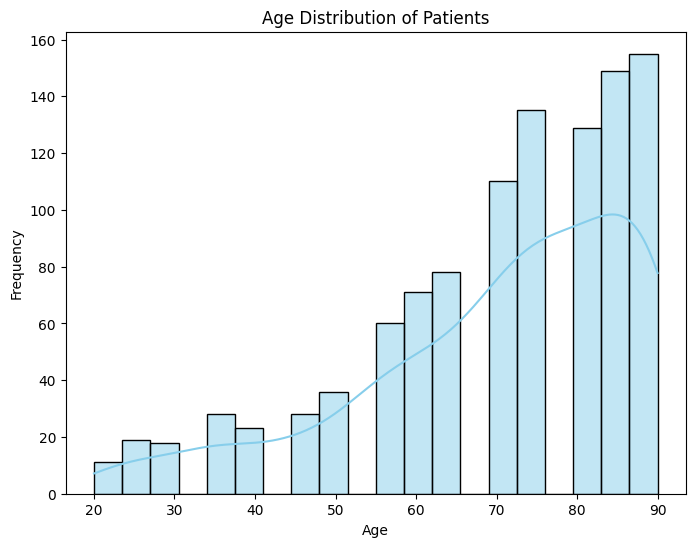

In [96]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a histogram of age distribution
plt.figure(figsize=(8, 6))
sns.histplot(df['Age'], bins=20, kde=True, color='skyblue')
plt.title('Age Distribution of Patients')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()


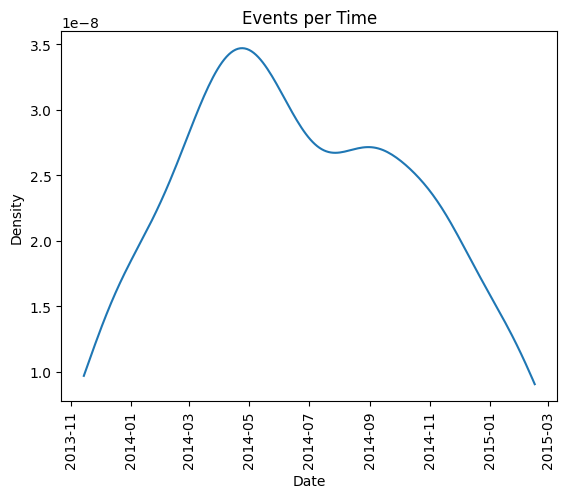

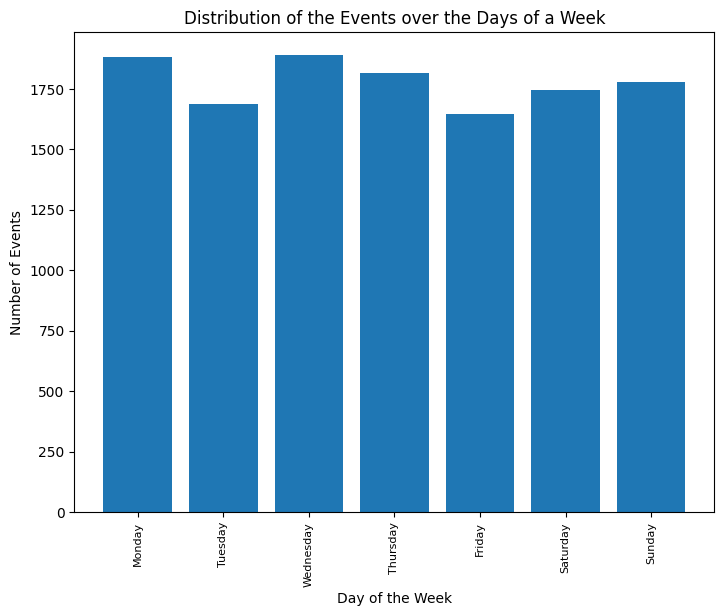

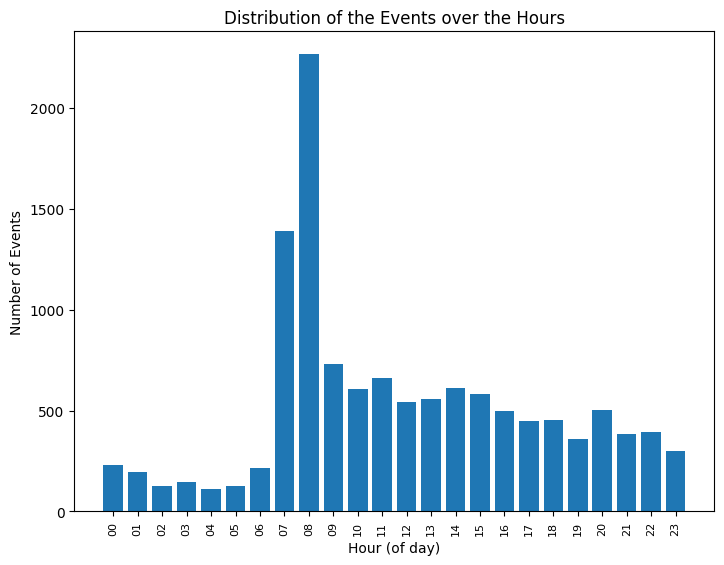

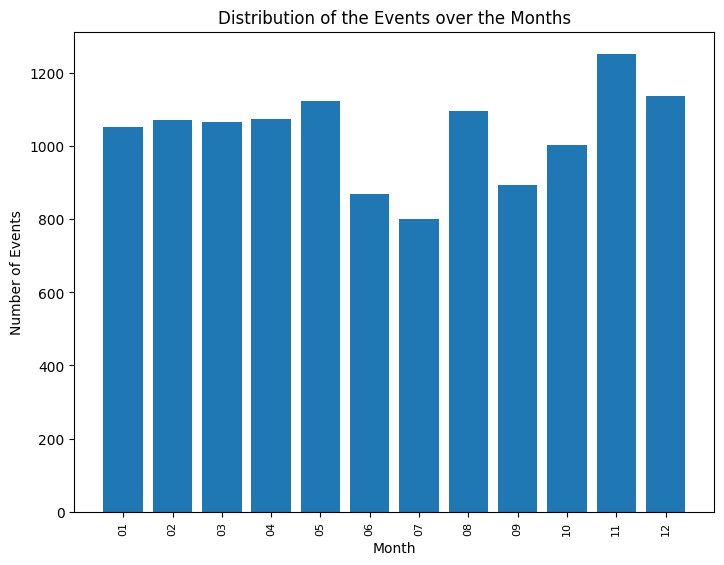

In [97]:
pm4py.view_events_per_time_graph(log)
pm4py.view_events_distribution_graph(log)
pm4py.view_events_distribution_graph(log, distr_type="hours")
pm4py.view_events_distribution_graph(log, distr_type="months")